
 ****** Running generation 0 ****** 

Population's average fitness: 2.26285 stdev: 0.38140
Best fitness: 2.99826 - size: (1, 2) - species 1 - id 2
Average adjusted fitness: 0.565
Mean genetic distance 1.268, standard deviation 0.423
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150      3.0    0.565     0
Total extinctions: 0
Generation time: 0.022 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.34856 stdev: 0.32106
Best fitness: 2.99894 - size: (1, 2) - species 1 - id 185
Average adjusted fitness: 0.600
Mean genetic distance 1.366, standard deviation 0.440
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150      3.0    0.600     0
Total extinctions: 0
Generation time: 0.021 sec (0.021 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.31204 stdev: 0.

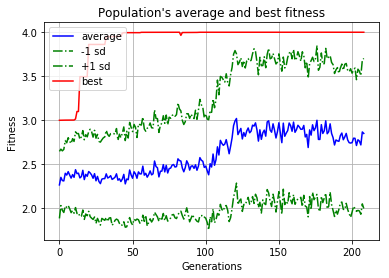

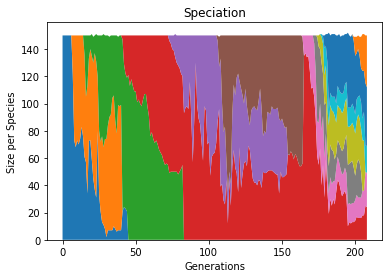

Mean genetic distance 1.656, standard deviation 0.558
Mean genetic distance 1.816, standard deviation 0.674
Mean genetic distance 1.901, standard deviation 0.715
Mean genetic distance 1.882, standard deviation 0.800
Mean genetic distance 2.035, standard deviation 0.837
Mean genetic distance 2.072, standard deviation 0.812
Mean genetic distance 2.148, standard deviation 0.749
Mean genetic distance 2.145, standard deviation 0.628
Mean genetic distance 2.030, standard deviation 0.641
Mean genetic distance 1.886, standard deviation 0.605


In [14]:
"""
2-input XOR example -- this is most likely the simplest possible example.
"""

from __future__ import print_function
import os
import neat
import visualize

# 2-input XOR inputs and expected outputs.
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [   (0.0,),     (1.0,),     (1.0,),     (0.0,)]


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = len(xor_inputs)
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2


def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(xor_inputs, xor_outputs):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1:'A', -2: 'B', 0:'A XOR B'}
    visualize.draw_net(config, winner, True, node_names=node_names)
    visualize.plot_stats(stats, ylog=False, view=True)
    visualize.plot_species(stats, view=True)

    p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    p.run(eval_genomes, 10)


if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    config_path = "config-feedforward"
    run(config_path)

In [21]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [16]:
G = nx.read_gml("galFiltered.gml").to_undirected()
G = max(nx.connected_component_subgraphs(G), key=len)

In [19]:
labels = nx.get_node_attributes(G, "label")

genes_in_network = labels.values()

expression_data = pd.read_csv("galExpData.csv")

genes_in_expression_data = expression_data.loc[:,["GENE"]].as_matrix().flatten()

genes_in_network = [gene for gene in genes_in_network if gene in genes_in_expression_data]

# subnetwork that is labelled
nodes_of_interest = [k for k, v in nx.get_node_attributes(G, "label").items() if v in genes_in_network]
G = G.subgraph(nodes_of_interest)

N = nx.number_of_nodes(G)

p_values = expression_data.set_index("GENE").loc[genes_in_network,["gal1RGsig", "gal4RGsig", "gal80Rsig"]].as_matrix()

In [24]:
z_values = norm.ppf(1 - p_values)
z_values[z_values < 0] = 0
z_values = z_values[:, 0, np.newaxis]

In [30]:
A = np.array(nx.adjacency_matrix(G).todense())
Z = z_values.dot(z_values.transpose())

A = Z * A

In [31]:
G = nx.from_numpy_matrix(A)
G = max(nx.connected_component_subgraphs(G), key=len)

In [32]:
labels = {k: v for k,v in labels.items() if k in G.nodes()}

nx.set_node_attributes(G, "label", labels)

In [33]:
N = nx.number_of_nodes(G)

In [34]:
A = np.array(nx.adjacency_matrix(G).todense())
D = A.sum(axis=0)

In [36]:
W = (np.identity(N) + A.dot(np.diag(1./D))) / 2

In [42]:
def matrix_multiply(M, n):
    if n == 0:
        return np.identity(M.shape[0])
    if n % 2 == 0:
        m = matrix_multiply(M, n/2).dot(matrix_multiply(M, n/2))
    else: m = M.dot(matrix_multiply(M, n-1))
    m[m < 0] = 0
    return m / m.sum(axis=0)

In [46]:
targets = matrix_multiply(W, 100).transpose()

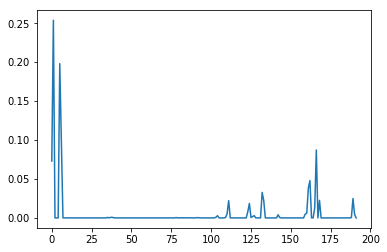

In [47]:
plt.plot(targets[0])

In [68]:
def hyperbolic_distance(xi, xj):
    if np.array_equal(xi, xj): return 0
    delta =np.pi - np.abs(np.pi - np.abs(xi[1] - xj[1]))
    d = np.cosh(xi[0]) * np.cosh(xj[0]) - np.sinh(xi[0]) * np.sinh(xj[0]) * np.cos(delta)
    if d < 1: d = 1
    d = np.arccosh(d)
    return d

In [122]:
def compute_probabilities(X):
    
    D = np.array([[hyperbolic_distance(xi, xj) for xj in X] for xi in X])
    
    P = np.exp(-D)
    
    return P / P.sum(axis=1)[:,np.newaxis]
    

In [166]:
X = np.column_stack([np.random.rand(N) * 10, np.random.rand(N) * 2 * np.pi])

In [167]:
P = compute_probabilities(X)

In [168]:
from scipy.stats import entropy

In [169]:
entropy(targets, P).sum()

1058.7007484312549

In [171]:
N

192

In [181]:
%%prun

from __future__ import print_function
import os
import neat
import visualize

# inputs and expected outputs.
inputs = np.identity(N)
expected_outputs = targets

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        
        embeddings = np.array([net.activate(x) for x in inputs])    
        predicted_probabilities = compute_probabilities(embeddings)
        
        genome.fitness = - entropy(expected_outputs, predicted_probabilities).sum()
        
#         genome.fitness = np.random.rand()
    
#         for xi, xo in zip(inputs, xor_outputs):
#             output = net.activate(xi)
            
#             genome.fitness -= entropy(xo, output)


def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 10)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

#     # Show output of the most fit genome against training data.
#     print('\nOutput:')
#     winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
#     for xi, xo in zip(xor_inputs, xor_outputs):
#         output = winner_net.activate(xi)
#         print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

#     node_names = {-1:'A', -2: 'B', 0:'A XOR B'}
#     visualize.draw_net(config, winner, True, node_names=node_names)
#     visualize.plot_stats(stats, ylog=False, view=True)
#     visualize.plot_species(stats, view=True)

#     p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
#     p.run(eval_genomes, 10)


if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    config_path = "embedder_config"
    run(config_path)


 ****** Running generation 0 ****** 

Population's average fitness: -226.59033 stdev: 2.58447
Best fitness: -221.35490 - size: (2, 384) - species 1 - id 8
Average adjusted fitness: 0.510
Mean genetic distance 1.340, standard deviation 0.242
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150   -221.4    0.510     0
Total extinctions: 0
Generation time: 133.252 sec

 ****** Running generation 1 ****** 

Population's average fitness: -225.92610 stdev: 8.94778
Best fitness: -220.49571 - size: (3, 383) - species 1 - id 206
Average adjusted fitness: 0.920
Mean genetic distance 1.440, standard deviation 0.282
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150   -220.5    0.920     0
Total extinctions: 0
Generation time: 131.341 sec (132.297 average)

 ****** Running generation 2 ****** 

Population's average fitn